# Robust Zero-Shot Classification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torchattacks

In [2]:
!pip install peft -q

In [4]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset, Dataset
from transformers import CLIPProcessor, CLIPModel
import torchattacks
import os
import glob
import gc
from peft import LoraConfig, get_peft_model
import torch.nn as nn
from tqdm import tqdm

In [5]:
base_path = "/content/drive/MyDrive/Colab Notebooks/HW5"
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1: Preparing CIFAR10 dataset

### Download dataset

In [ ]:
trainset_raw = CIFAR10(root= base_path+'/CIFAR10/train', train=True, download=True)

testset_raw = CIFAR10(root= base_path +'/CIFAR10/test', train=False, download=True)

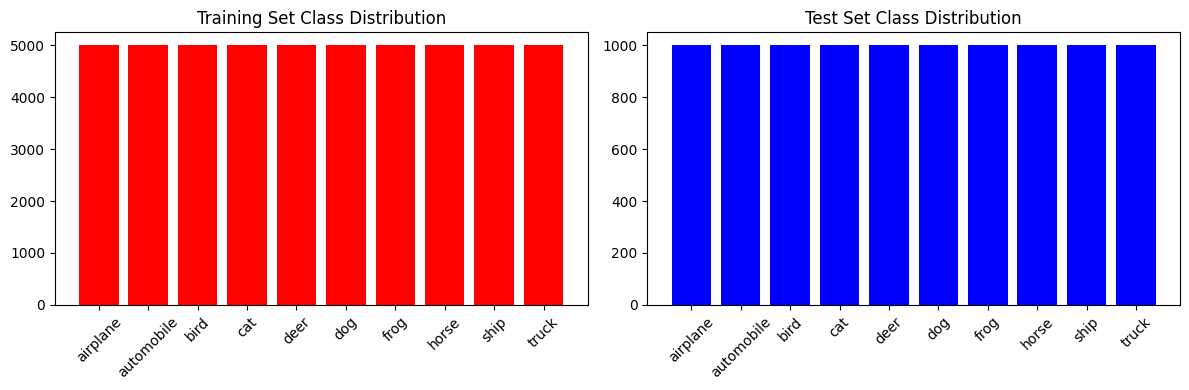

In [ ]:
class_names = trainset_raw.classes

train_labels = [label for _, label in trainset_raw]
test_labels = [label for _, label in testset_raw]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

train_distribution = [train_counts[i] for i in range(10)]
test_distribution = [test_counts[i] for i in range(10)]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar(class_names, train_distribution, color='r')
axs[0].set_title("Training Set Class Distribution")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(class_names, test_distribution, color='b')
axs[1].set_title("Test Set Class Distribution")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
def show_random_images(dataset, num_images=5):

    class_names = dataset.classes

    random_indices = random.sample(range(len(dataset)), num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f'{num_images} Random Images from CIFAR-10 Training Set', fontsize=16)

    for i, index in enumerate(random_indices):
        image, label = dataset[index]
        axes[i].imshow(image)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

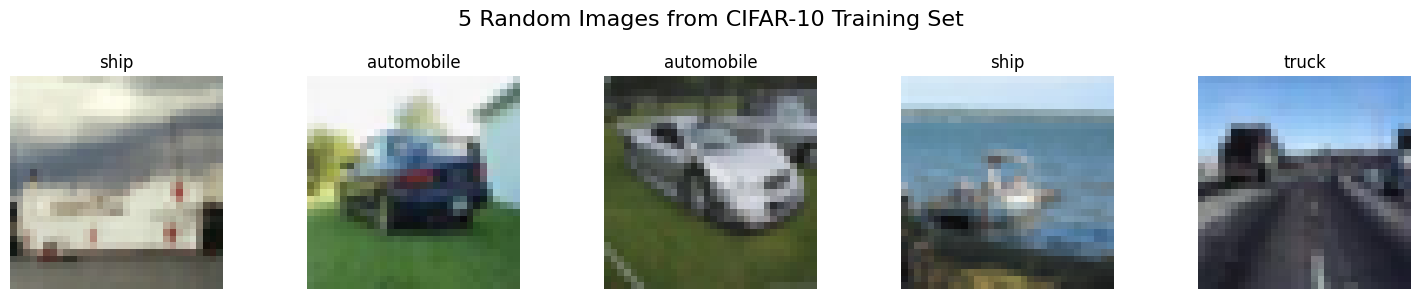

In [ ]:
show_random_images(trainset_raw, num_images=5)

### Processing images

In [6]:
CLIP_MEAN = [0.48145466, 0.4578275, 0.40821073]
CLIP_STD = [0.26862954, 0.26130258, 0.27577711]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(CLIP_MEAN, CLIP_STD)
])

In [7]:
full_train_dataset = CIFAR10(
    root=base_path + '/CIFAR10/train',
    train=True,
    download=True,
    transform=transform
)

train_val_ratio = 0.9
train_size = int(train_val_ratio * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

test_dataset = CIFAR10(
    root=base_path +'/CIFAR10/test',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2, pin_memory=False)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)

print(f"Train samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")

images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

Train samples: 45000
Validation samples: 5000
Test samples: 10000
Batch image shape: torch.Size([64, 3, 224, 224])
Batch labels shape: torch.Size([64])


## 2: Loading CLIP and adversarial model

### CLIP

In [8]:
model_name = "openai/clip-vit-base-patch32"

CLIP_model = CLIPModel.from_pretrained(model_name)
CLIP_processor = CLIPProcessor.from_pretrained(model_name)

CLIP_model.to(device)
CLIP_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

### Adversarial model

In [9]:
adversarial_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
adversarial_model.to(device)
adversarial_model.eval()

for param in adversarial_model.parameters():
        param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 32.8MB/s

### Generating text prompts

In [10]:
class_names = full_train_dataset.classes
print("Class names from dataset:")
print(class_names)

Class names from dataset:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
prompts = [f"a photo of a {class_name}" for class_name in class_names]
print("Text prompts:")
for prompt in prompts:
  print(prompt)

Text prompts:
a photo of a airplane
a photo of a automobile
a photo of a bird
a photo of a cat
a photo of a deer
a photo of a dog
a photo of a frog
a photo of a horse
a photo of a ship
a photo of a truck


In [12]:
# Processing and tokenization
text_inputs = CLIP_processor(
    text=prompts,
    return_tensors="pt",
    padding=True
)
text_inputs = {key: value.to(device) for key, value in text_inputs.items()}

In [13]:
# Normalization
with torch.no_grad():
    text_features = CLIP_model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
print(f"Text features tensor shape: {text_features.shape}")

Text features tensor shape: torch.Size([10, 512])


## 3: Evaluating CLIP on clean and adverse images

### Clean Images

In [14]:
def evaluate_clip(model, dataloader, text_features, device):

    model.eval()

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)  # Already normalized
            labels = labels.to(device)

            image_features = model.get_image_features(pixel_values=images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = image_features @ text_features.T

            predictions = similarity.argmax(dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return accuracy

In [ ]:
test_accuracy = evaluate_clip(CLIP_model, test_loader, text_features, device)

print(f"CLIP's Zero-Shot Accuracy on CIFAR-10 test set (Clean images): {test_accuracy:.2f}%")

CLIP's Zero-Shot Accuracy on CIFAR-10 test set (Clean images): 87.83%


### Adverse Images

#### Creating adverse dataset

In [ ]:
def evaluate_CLIP_on_adversarial(clip_model, attack_model, dataloader, text_features, device):

    clip_model.eval()
    attack_model.eval()

    for param in attack_model.parameters():
        param.requires_grad = False

    atk = torchattacks.PGD(attack_model, eps=8/255, alpha=2/255, steps=7)

    total_correct = 0
    total_samples = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        adv_images = atk(images, labels)

        with torch.no_grad():
            image_features = clip_model.get_image_features(pixel_values=adv_images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = image_features @ text_features.T
            predictions = similarity.argmax(dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = (total_correct / total_samples) * 100
    return accuracy

In [ ]:
adversarial_accuracy = evaluate_CLIP_on_adversarial(
    clip_model=CLIP_model,
    attack_model=adversarial_model,
    dataloader=test_loader,
    text_features=text_features,
    device=device
)

print(f"CLIP's Accuracy on Adversarial Examples: {adversarial_accuracy:.2f}%")

CLIP's Accuracy on Adversarial Examples: 54.88%


In [ ]:
############

In [15]:
atk = torchattacks.PGD(adversarial_model, eps=8/255, alpha=2/255, steps=7)

num_samples = len(test_loader.dataset)
sample_image, _ = test_loader.dataset[0]
C, H, W = sample_image.shape

adv_images_tensor = torch.empty((num_samples, C, H, W), dtype=torch.float32, device='cpu')
labels_tensor = torch.empty((num_samples,), dtype=torch.long, device='cpu')

start_idx = 0
for images, labels in test_loader:
    images = images.to(device)
    labels_gpu = labels.to(device)

    adv_batch = atk(images, labels_gpu)

    end_idx = start_idx + len(images)

    adv_images_tensor[start_idx:end_idx] = adv_batch.cpu()
    labels_tensor[start_idx:end_idx] = labels.cpu()

    start_idx = end_idx

del images, labels, adv_batch
gc.collect()
torch.cuda.empty_cache()

adversarial_dataset = TensorDataset(adv_images_tensor, labels_tensor)
adversarial_loader = DataLoader(adversarial_dataset, batch_size=32, shuffle=False)

In [16]:
del adv_images_tensor
del labels_tensor
del adversarial_dataset

gc.collect()

0

In [ ]:
adversarial_accuracy = evaluate_clip(CLIP_model, adversarial_loader, text_features, device)

print(f"CLIP's Accuracy on Adversarial Examples: {adversarial_accuracy:.2f}%")

CLIP's Accuracy on Adversarial Examples: 54.67%


#### Show an example of adverse image

In [17]:
def unnormalize(tensor, mean, std):
    tensor = tensor.clone().cpu()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.permute(1, 2, 0)

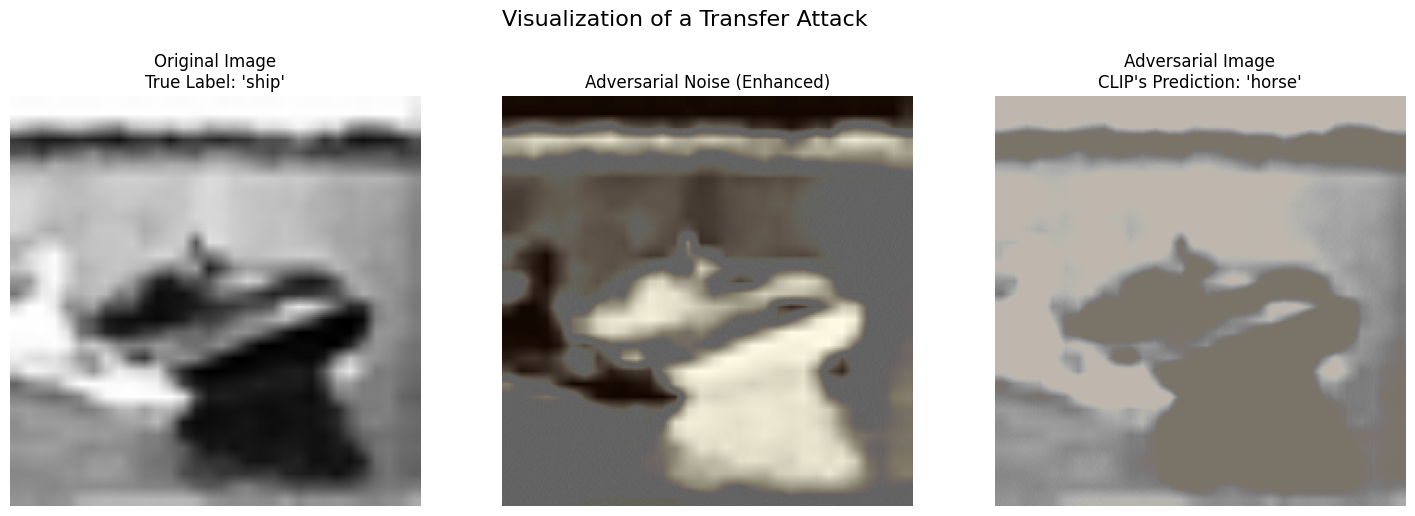

In [ ]:
sample_idx = 150
original_image_tensor, original_label = test_dataset[sample_idx]

original_image_for_attack = original_image_tensor.unsqueeze(0).to(device)
original_label_tensor = torch.tensor([original_label]).to(device)

atk.model.eval()
adversarial_image_tensor = atk(original_image_for_attack, original_label_tensor).squeeze(0).cpu()

noise_tensor = adversarial_image_tensor - original_image_tensor

noise_to_show = (noise_tensor - noise_tensor.min()) / (noise_tensor.max() - noise_tensor.min())

original_img_show = unnormalize(original_image_tensor, CLIP_MEAN, CLIP_STD)
adversarial_img_show = unnormalize(adversarial_image_tensor, CLIP_MEAN, CLIP_STD)

with torch.no_grad():
    adv_img_for_pred = adversarial_image_tensor.unsqueeze(0).to(device)
    adv_img_features = CLIP_model.get_image_features(pixel_values=adv_img_for_pred)
    adv_img_features /= adv_img_features.norm(dim=-1, keepdim=True)
    similarity = adv_img_features @ text_features.T
    prediction_idx = similarity.argmax().item()
    predicted_class = class_names[prediction_idx]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Visualization of a Transfer Attack", fontsize=16)

axs[0].imshow(original_img_show.clamp(0, 1))
axs[0].set_title(f"Original Image\nTrue Label: '{class_names[original_label]}'")
axs[0].axis('off')

axs[1].imshow(noise_to_show.permute(1, 2, 0))
axs[1].set_title("Adversarial Noise (Enhanced)")
axs[1].axis('off')

axs[2].imshow(adversarial_img_show.clamp(0, 1))
axs[2].set_title(f"Adversarial Image\nCLIP's Prediction: '{predicted_class}'")
axs[2].axis('off')

plt.show()

## 4: Finetuning CLIP model using LoRA method (Normal adversarial loss)

### LoRA configue

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none"
)

model = CLIPModel.from_pretrained(model_name).to(device)
lora_model = get_peft_model(model.vision_model, lora_config)

model.vision_model = lora_model

lora_model.print_trainable_parameters()

trainable params: 442,368 || all params: 87,898,368 || trainable%: 0.5033


### Training model

In [22]:
num_train_samples_to_use = len(test_dataset)

num_remaining_in_train = len(train_subset) - num_train_samples_to_use

train_subset_10k, _ = random_split(
    train_subset,
    [num_train_samples_to_use, num_remaining_in_train],
    generator=generator
)

train_loader_10k = DataLoader(train_subset_10k, batch_size=64, shuffle=True)

In [ ]:
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()
num_epochs = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader_10k, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        adv_images = atk(images, labels)

        image_features = model.get_image_features(pixel_values=adv_images)

        logits = image_features @ text_features.T

        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": running_loss / (progress_bar.n + 1)})

Epoch 1/1: 100%|██████████| 157/157 [06:39<00:00,  2.54s/it, Loss=0.78]


### Evaluate finetuned model on clean images

In [ ]:
model.eval()

clean_accuracy_after = evaluate_clip(model, test_loader, text_features, device)
print(f"Clean Accuracy after LoRA tuning: {clean_accuracy_after:.2f}%")

Clean Accuracy after LoRA tuning: 93.29%


### Evaluate finetuned model on adverse images

In [ ]:
adversarial_accuracy_after = evaluate_clip(model, adversarial_loader, text_features, device)
print(f"Adversarial Accuracy after LoRA tuning: {adversarial_accuracy_after:.2f}%")

Adversarial Accuracy after LoRA tuning: 83.68%


## 5: Implementing TeCoA loss

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none"
)

model = CLIPModel.from_pretrained(model_name).to(device)
lora_model_tecoa = get_peft_model(model.vision_model, lora_config)

model.vision_model = lora_model_tecoa

lora_model_tecoa.print_trainable_parameters()

trainable params: 442,368 || all params: 87,898,368 || trainable%: 0.5033


### Training model

In [ ]:
############# 1
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 1

for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader_10k, desc=f"Epoch {epoch+1}/{num_epochs} (TeCoA)")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        adv_images = atk(images, labels)


        image_features = model.get_image_features(pixel_values=adv_images)
        normalized_image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logits = normalized_image_features @ text_features.T * model.logit_scale.exp()

        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"Loss": loss.item()})


Epoch 1/1 (TeCoA): 100%|██████████| 157/157 [06:39<00:00,  2.54s/it, Loss=0.319]


In [ ]:
################ 2
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 1

for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader_10k, desc=f"Epoch {epoch+1}/{num_epochs} (TeCoA)")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        adv_images = atk(images, labels)


        image_features = model.get_image_features(pixel_values=adv_images)
        normalized_image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logits = normalized_image_features @ text_features.T * model.logit_scale.exp()

        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"Loss": loss.item()})


Epoch 1/1 (TeCoA): 100%|██████████| 157/157 [06:38<00:00,  2.54s/it, Loss=0.413]


In [ ]:
################ 3
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 1

for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader_10k, desc=f"Epoch {epoch+1}/{num_epochs} (TeCoA)")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        adv_images = atk(images, labels)


        image_features = model.get_image_features(pixel_values=adv_images)
        normalized_image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logits = normalized_image_features @ text_features.T * model.logit_scale.exp()

        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"Loss": loss.item()})


Epoch 1/1 (TeCoA): 100%|██████████| 157/157 [06:39<00:00,  2.54s/it, Loss=0.569]


### Evaluate finetuned model on clean images (TeCoA loss)

In [ ]:
##############1
model.eval()

clean_accuracy_after_tecoa = evaluate_clip(model, test_loader, text_features, device)
print(f"Clean Accuracy after LoRA tuning (TeCoA loss): {clean_accuracy_after_tecoa:.2f}%")

Clean Accuracy after LoRA tuning (TeCoA loss): 93.09%


In [ ]:
############## 2
model.eval()

clean_accuracy_after_tecoa = evaluate_clip(model, test_loader, text_features, device)
print(f"Clean Accuracy after LoRA tuning (TeCoA loss): {clean_accuracy_after_tecoa:.2f}%")

Clean Accuracy after LoRA tuning (TeCoA loss): 90.08%


In [ ]:
############## 3
model.eval()

clean_accuracy_after_tecoa = evaluate_clip(model, test_loader, text_features, device)
print(f"Clean Accuracy after LoRA tuning (TeCoA loss): {clean_accuracy_after_tecoa:.2f}%")

Clean Accuracy after LoRA tuning (TeCoA loss): 88.14%


### Evaluate finetuned model on adverse images (TeCoA loss)

In [ ]:
############## 1
adversarial_accuracy_after_tecoa = evaluate_clip(model, adversarial_loader, text_features, device)
print(f"Adversarial Accuracy after LoRA tuning (TeCoA loss): {adversarial_accuracy_after_tecoa:.2f}%")

Adversarial Accuracy after LoRA tuning (TeCoA loss): 83.54%


In [ ]:
############## 2
adversarial_accuracy_after_tecoa = evaluate_clip(model, adversarial_loader, text_features, device)
print(f"Adversarial Accuracy after LoRA tuning (TeCoA loss): {adversarial_accuracy_after_tecoa:.2f}%")

Adversarial Accuracy after LoRA tuning (TeCoA loss): 85.28%


In [ ]:
############## 3
adversarial_accuracy_after_tecoa = evaluate_clip(model, adversarial_loader, text_features, device)
print(f"Adversarial Accuracy after LoRA tuning (TeCoA loss): {adversarial_accuracy_after_tecoa:.2f}%")

Adversarial Accuracy after LoRA tuning (TeCoA loss): 86.50%


## 7: Visual Prompting Tuning (VPT)

In [29]:
vpt_model = CLIPModel.from_pretrained(model_name).to(device)

for param in vpt_model.parameters():
    param.requires_grad = False

### Adding 10 tokens to input images

In [28]:
###### 1
prompt_length = 10
embed_dim = vpt_model.config.vision_config.hidden_size
visual_prompt = nn.Parameter(torch.randn(1, prompt_length, embed_dim, device=device))
visual_prompt.requires_grad = True

print(f"Visual Prompt shape: {visual_prompt.shape}")
print(f"Total trainable parameters: {sum(p.numel() for p in vpt_model.parameters() if p.requires_grad) + visual_prompt.numel()}")


Visual Prompt shape: torch.Size([1, 10, 768])
Total trainable parameters: 7680


In [20]:
def get_image_features_with_prompt(model, pixel_values, prompt):

    image_embeds = model.vision_model.embeddings(pixel_values)

    prompt_batch = prompt.expand(image_embeds.shape[0], -1, -1)
    input_with_prompt = torch.cat([
        image_embeds[:, :1, :],
        prompt_batch,
        image_embeds[:, 1:, :]
    ], dim=1)

    hidden_states = model.vision_model.pre_layrnorm(input_with_prompt)


    encoder_outputs = model.vision_model.encoder(hidden_states)

    pooled_output = encoder_outputs.last_hidden_state[:, 0, :]
    pooled_output = model.vision_model.post_layernorm(pooled_output)

    projected_output = model.visual_projection(pooled_output)

    return projected_output

### Training model

In [ ]:
##### 1 epoch
optimizer_vpt = torch.optim.AdamW([visual_prompt], lr=1e-2)

loss_fn = nn.CrossEntropyLoss()
num_epochs = 1

vpt_model.train()

for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader_10k, desc=f"Epoch {epoch+1}/{num_epochs} (VPT + TeCoA)")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        adv_images = atk(images, labels)

        image_features = get_image_features_with_prompt(vpt_model, adv_images, visual_prompt)

        normalized_image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = normalized_image_features @ text_features.T * vpt_model.logit_scale.exp()

        loss = loss_fn(logits, labels)

        optimizer_vpt.zero_grad()
        loss.backward()
        optimizer_vpt.step()

        progress_bar.set_postfix({"Loss": loss.item()})

Epoch 1/1 (VPT + TeCoA): 100%|██████████| 157/157 [06:43<00:00,  2.57s/it, Loss=0.642]


In [30]:
##### 5 epochs
optimizer_vpt = torch.optim.AdamW([visual_prompt], lr=1e-2)

loss_fn = nn.CrossEntropyLoss()
num_epochs = 5

vpt_model.train()

for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader_10k, desc=f"Epoch {epoch+1}/{num_epochs} (VPT + TeCoA)")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        adv_images = atk(images, labels)

        image_features = get_image_features_with_prompt(vpt_model, adv_images, visual_prompt)

        normalized_image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = normalized_image_features @ text_features.T * vpt_model.logit_scale.exp()

        loss = loss_fn(logits, labels)

        optimizer_vpt.zero_grad()
        loss.backward()
        optimizer_vpt.step()

        progress_bar.set_postfix({"Loss": loss.item()})

Epoch 5/5 (VPT + TeCoA): 100%|██████████| 157/157 [06:49<00:00,  2.61s/it, Loss=0.974]


### Evaluate VPT model on clean images (TeCoA loss)

In [25]:
def evaluate_vpt(model, prompt, dataloader, text_features, device):

    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Clean Eval (VPT)")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            image_features = get_image_features_with_prompt(model, images, prompt)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_features.T * model.logit_scale.exp()
            predictions = logits.argmax(dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)

    accuracy = (total_correct / total_samples) * 100
    return accuracy

In [ ]:
######## 1 epoch
vpt_model.eval()

clean_accuracy_vpt = evaluate_vpt(vpt_model, visual_prompt, test_loader, text_features, device)
print(f"Clean Accuracy after VPT tuning: {clean_accuracy_vpt:.2f}%")

Clean Eval (VPT): 100%|██████████| 313/313 [00:36<00:00,  8.47it/s]

Clean Accuracy after VPT tuning: 86.82%


In [31]:
####### 5 epoch
vpt_model.eval()

clean_accuracy_vpt = evaluate_vpt(vpt_model, visual_prompt, test_loader, text_features, device)
print(f"Clean Accuracy after VPT tuning: {clean_accuracy_vpt:.2f}%")

Clean Eval (VPT): 100%|██████████| 313/313 [00:38<00:00,  8.18it/s]

Clean Accuracy after VPT tuning: 88.52%


### Evaluate VPT model on adverse images (TeCoA loss)

In [ ]:
###### 1 epoch
adversarial_accuracy_vpt = evaluate_vpt(vpt_model, visual_prompt, adversarial_loader, text_features, device)
print(f"Adversarial Accuracy after VPT tuning: {adversarial_accuracy_vpt:.2f}%")

Clean Eval (VPT): 100%|██████████| 313/313 [00:34<00:00,  9.09it/s]

Adversarial Accuracy after VPT tuning: 64.14%


In [32]:
###### 2 epochs
adversarial_accuracy_vpt = evaluate_vpt(vpt_model, visual_prompt, adversarial_loader, text_features, device)
print(f"Adversarial Accuracy after VPT tuning: {adversarial_accuracy_vpt:.2f}%")

Clean Eval (VPT): 100%|██████████| 313/313 [00:35<00:00,  8.79it/s]

Adversarial Accuracy after VPT tuning: 74.02%
